# 1. Collect and label image data

In [2]:
import os 
import time
import uuid     # To create nique uniform identifier for collected images
import cv2      # For access camera sensors for image data collection

## 1.1 Collect the image data

In [3]:
IMAGES_PATH = os.path.join('data','train','images')
number_images = 30

In the code block below, we will capture a number of images from the camera. There will be a little delay between each image capture for the user to make slight adjustment to their faces and postures.

In [15]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_EXPOSURE,-6)

for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    
    ret, frame = cap.read()

    if not ret:
        print("There are some errors in the capture process")
        # break

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('Frame', frame)
    time.sleep(1.0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## 1.2 Label the image data

In [ ]:
!labelme 

2025-02-12 17:58:49.556 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\mnguyen6\.labelmerc


# 2. Review Dataset and Build Image Loading Function 

## 2.1 Import TF and dependencies

In [4]:
import tensorflow as tf 
import json         # For parsing the json label files
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'{len(gpus)} GPUs found')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1 GPUs found


## 2.3 Load Image in to TF Data Pipeline

In [7]:
images = tf. data.Dataset.list_files('data\\train\\images\\*.jpg',shuffle=False)

In [8]:
images.take(1)

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [9]:
images.as_numpy_iterator().next()

b'data\\train\\images\\28b03f66-e98b-11ef-8d00-4cd717a70326.jpg'

Helper function to load the images from the file path into an image generator object. This function first read the byte-encoded images and convert them to array of image pixel values.

This function is later [mapped]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map)) on to the generator with the image path to load the images

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
# Look at one image sample and its shape
print('Image pixel values \n',images.as_numpy_iterator().next())
print('\nImage shape ', images.as_numpy_iterator().next().shape)

Image pixel values 
 [[[242 249 241]
  [242 249 241]
  [242 250 239]
  ...
  [235 238 229]
  [237 238 230]
  [237 237 229]]

 [[241 248 240]
  [242 249 241]
  [242 250 239]
  ...
  [232 238 228]
  [235 236 228]
  [234 234 226]]

 [[238 248 239]
  [239 249 240]
  [240 250 241]
  ...
  [233 243 232]
  [238 241 234]
  [242 241 236]]

 ...

 [[231 248 240]
  [230 247 239]
  [228 245 239]
  ...
  [222 234 222]
  [219 230 216]
  [215 226 212]]

 [[228 247 241]
  [227 246 240]
  [225 244 238]
  ...
  [227 237 226]
  [222 233 219]
  [218 229 215]]

 [[227 246 240]
  [226 245 239]
  [225 244 238]
  ...
  [231 241 230]
  [227 238 224]
  [224 235 221]]]

Image shape  (480, 640, 3)


In [13]:
type(images)  # This is a tensorflow dataset object 

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 Display raw data with Matplotlib

Group the images in the generator into small batches of 4 images => [Data batching]((https://www.tensorflow.org/versions/r2.10/api_docs/python/tf/data/Dataset?_gl=1*13bt2ru*_up*MQ..*_ga*MTI5NTI1MDM4LjE3Mzk0NzE0MjM.*_ga_W0YLR4190T*MTczOTQ3MTQyMy4xLjAuMTczOTQ3MTQ0Ni4wLjAuMA..#map))

In [14]:
image_generator = images.batch(4).as_numpy_iterator()    # Batch the images into batches of 4

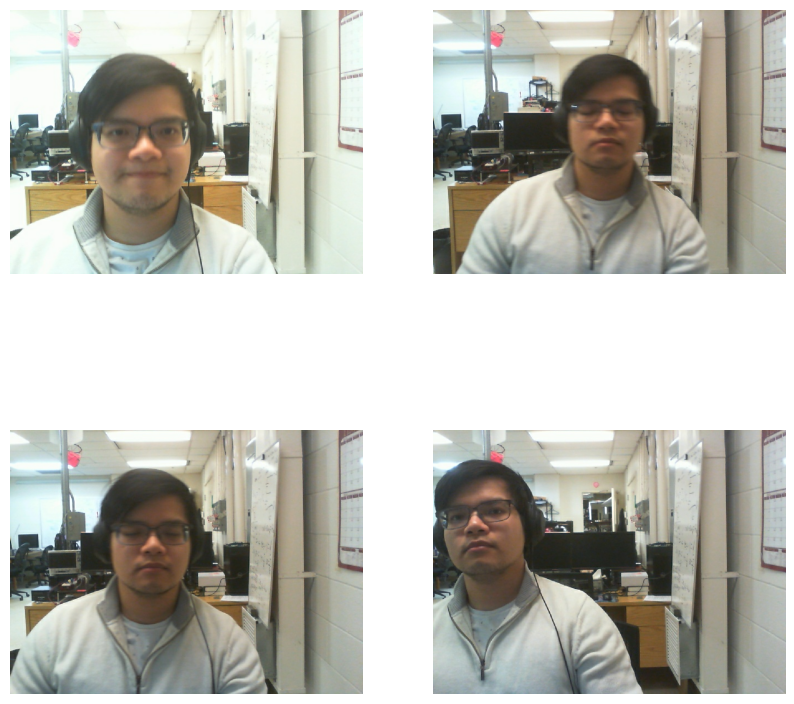

In [15]:
plot_images = image_generator.next()    # Get the next batch of images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for idx, image in enumerate(plot_images):
    ax[idx%2, idx//2].imshow(image)
    ax[idx%2, idx//2].axis('off')

plt.show()

# 3. Partition Unaugmented Data

In [ ]:
import random

def count_images(directories):
    """
    Function to count the number of images in a list of directories
    """
    return [len(tf.io.gfile.glob(os.path.join(directory, '*.jpg'))) for directory in directories]

def move_images(source_dir, target_dir, num_images):
    """
    Function to move images from one directory to another
    """
    images = tf.io.gfile.glob(os.path.join(source_dir, '*.jpg'))        # List of image paths in the source directory
    random.shuffle(images)
    for image_path in images[:num_images]:
        filename = os.path.basename(image_path)                         # Get the filename    
        target_path = os.path.join(target_dir, filename)                # Create the target path
        tf.io.gfile.copy(image_path, target_path, overwrite=True)       # Copy the image to the target path
        tf.io.gfile.remove(image_path)                                  # Remove the image from the source directory

def data_split(train_dir, val_dir, test_dir, desired_train=0.8, desired_val=0.2, seed=42):
    """
    Function to split the data (both images and labels) into training, validation, and possibly testing sets
    """
    # Calculate the proportion of images for training, validation, and testing
    total_proportion = desired_train + desired_val
    if total_proportion > 1:
        raise ValueError('The sum of desired_train and desired_val must not exceed 1')
    else:
        desired_test = 1 - total_proportion

    train_img_dir = os.path.join(train_dir, 'images')
    # Ensure the validation image directory exists
    val_img_dir = os.path.join(val_dir, 'images')
    os.makedirs(val_img_dir, exist_ok=True)
    # Ensure the test image directory exists (if provided)
    test_img_dir = os.path.join(test_dir, 'images')
    os.makedirs(test_img_dir, exist_ok=True)

    # Find the current number of images in train, val, and test
    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])
    total_images = train_count + val_count + test_count

    # Find the desired number of images in train, val, and test
    desired_train_count = int(total_images * desired_train)
    desired_val_count = int(total_images * desired_val) if desired_test else total_images - desired_train_count
    desired_test_count = total_images - desired_train_count - desired_val_count if desired_test else 0
    
    # Moving images between validation and test directories, then recount the images
    if val_count > desired_val_count:
        move_images(val_img_dir, test_img_dir, val_count - desired_val_count)
    elif val_count < desired_val_count:
        move_images(test_img_dir, val_img_dir, desired_val_count - val_count)

    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])

    # Moving the images between the training and test directories
    if test_count > desired_test_count:
        move_images(test_img_dir, train_img_dir, test_count - desired_test_count)
    elif test_count < desired_test_count:
        move_images(train_img_dir, test_img_dir, desired_test_count - test_count)

    # Find the current number of images in train, val, and test after the shift
    train_count, val_count, test_count = count_images([train_img_dir,val_img_dir,test_img_dir])

    return train_count, val_count, test_count

In [47]:
train_dir = 'data/train'
train_img_dir = os.path.join(train_dir,'images')
val_dir = 'data/val'
val_img_dir = os.path.join(val_dir,'images')
test_dir = 'data/test'
test_img_dir = os.path.join(val_dir,'images')

data_split(train_dir, val_dir, test_dir, 
           desired_train=0.8, 
           desired_val=0.1)

In [27]:
label_dir = 'data\\labels'
os.path.join(label_dir,'*.json')

'data\\labels\\*.json'

In [ ]:
label_dir = 'data\\labels'
all_labels = tf.data.Dataset.list_files(os.path.join(label_dir,'*.json'), shuffle=False)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [38]:
os.getcwd()

'c:\\Minh Nguyen\\experiment'